In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 1
commitnumber = 2bd1f75
conc = None
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0, 0, 0]
ng_refs = [3, 3, 6]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (30, 250), (300, 250)]
tsfc = 294
vmax = 340
vmin = 20
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66, 1.66), (1.66, 1.66, 1.5, 1.5, 1.5, 1.5)]
wgt = [(0.2, 0.2, 0.2), (0.2, 0.2, 0.2), (0.2, 0.2, 0.65, 0.65, 0.65, 0.65)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

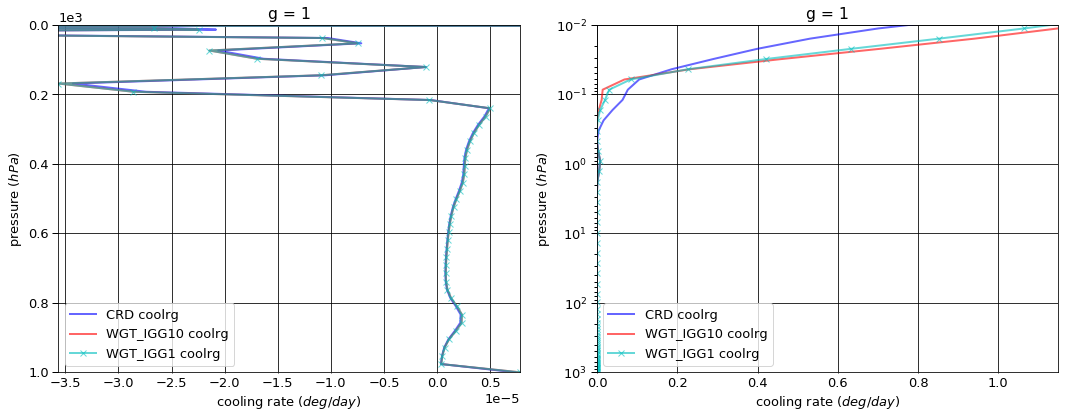

# Figure: cooling rate g-group 2

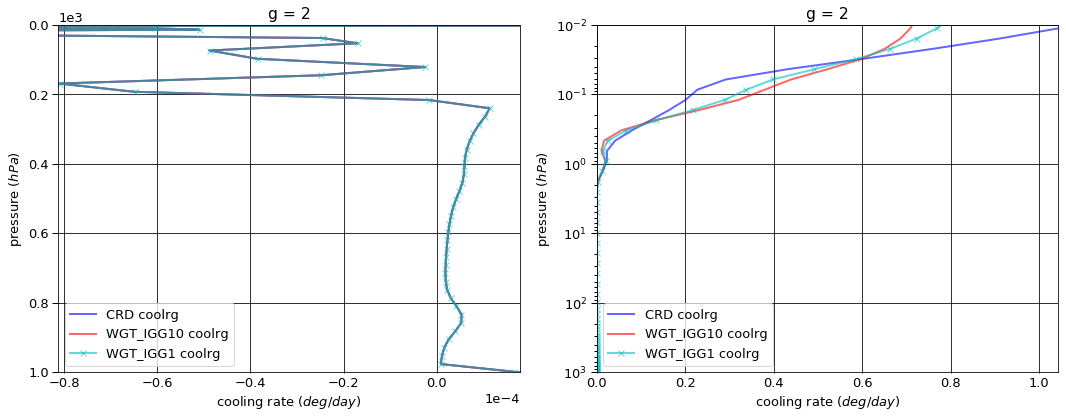

# Figure: cooling rate g-group 3

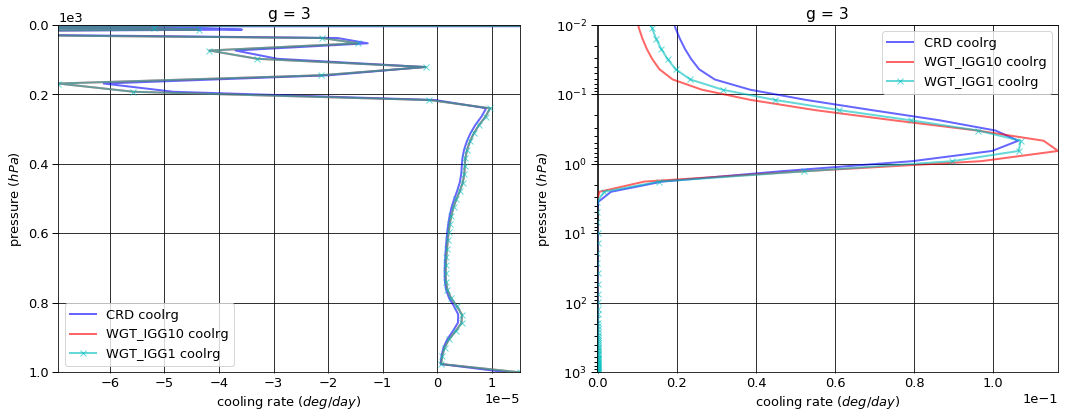

# Figure: cooling rate g-group 4

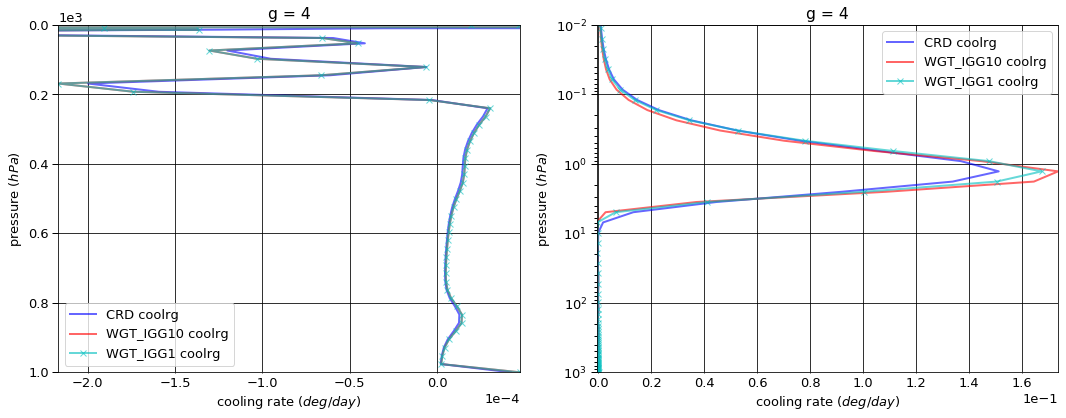

# Figure: cooling rate g-group 5

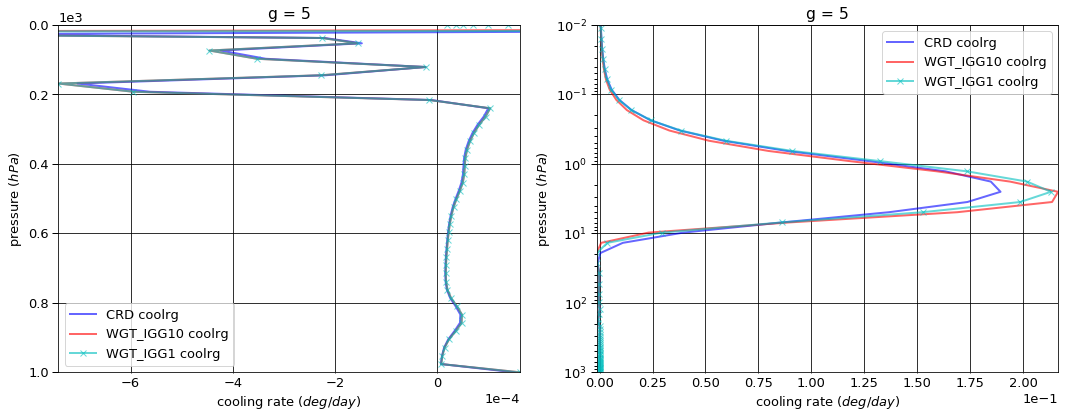

# Figure: cooling rate g-group 6

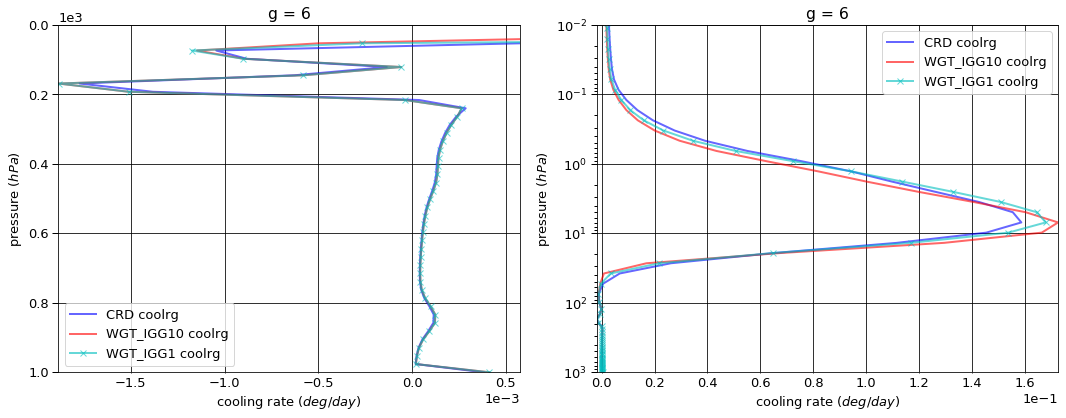

# Figure: cooling rate g-group 7

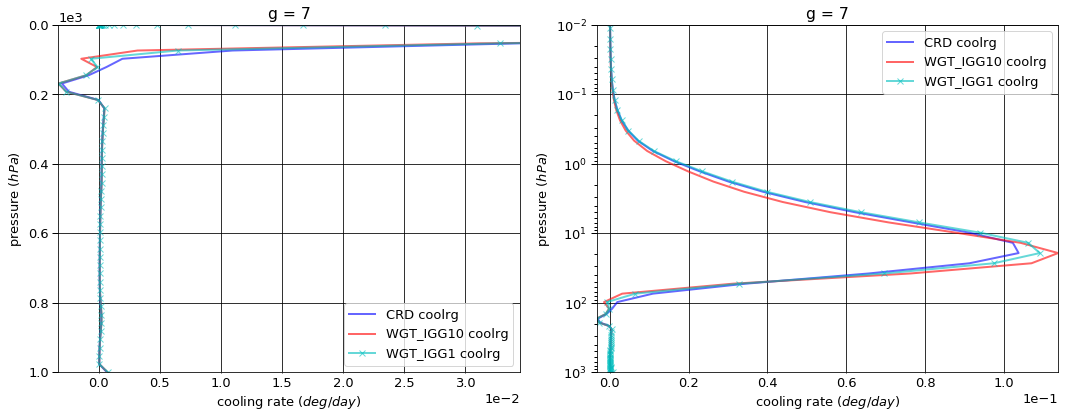

# Figure: cooling rate g-group 8

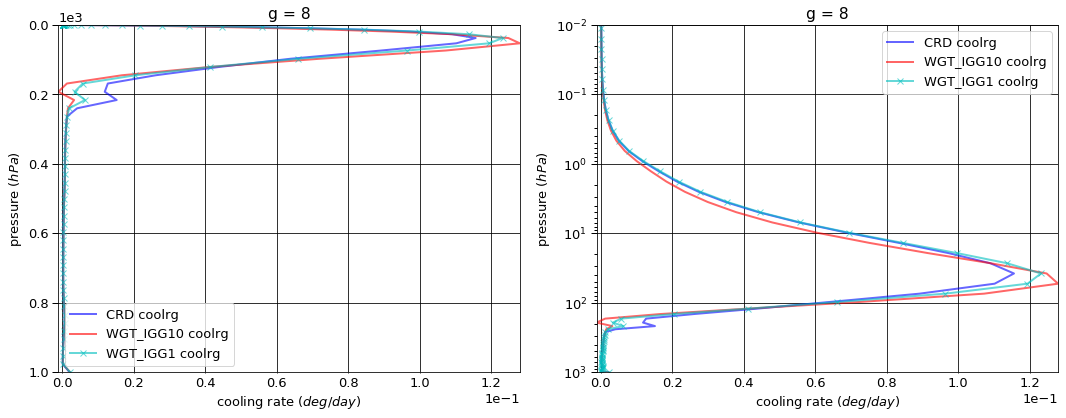

# Figure: cooling rate g-group 9

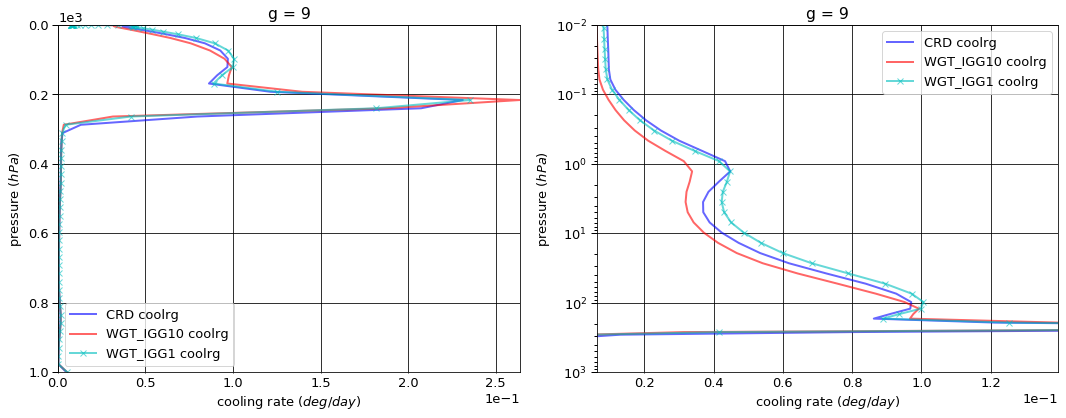

# Figure: cooling rate g-group 10

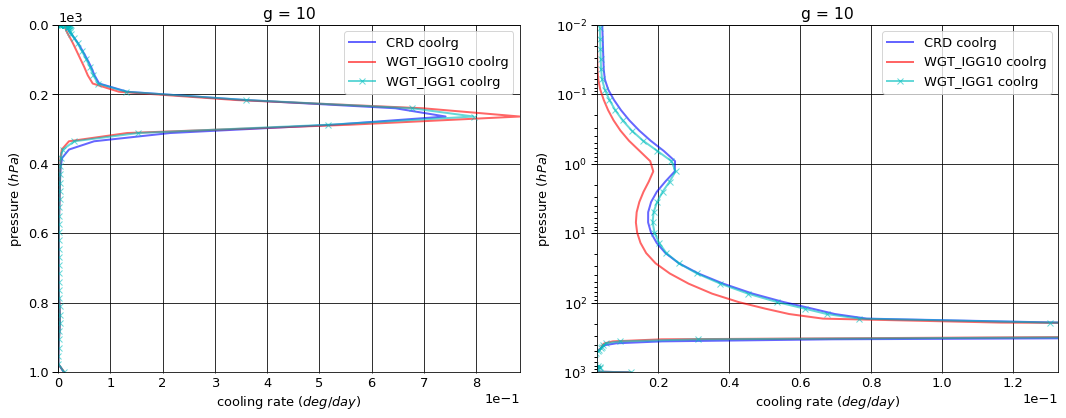

# Figure: cooling rate g-group 11

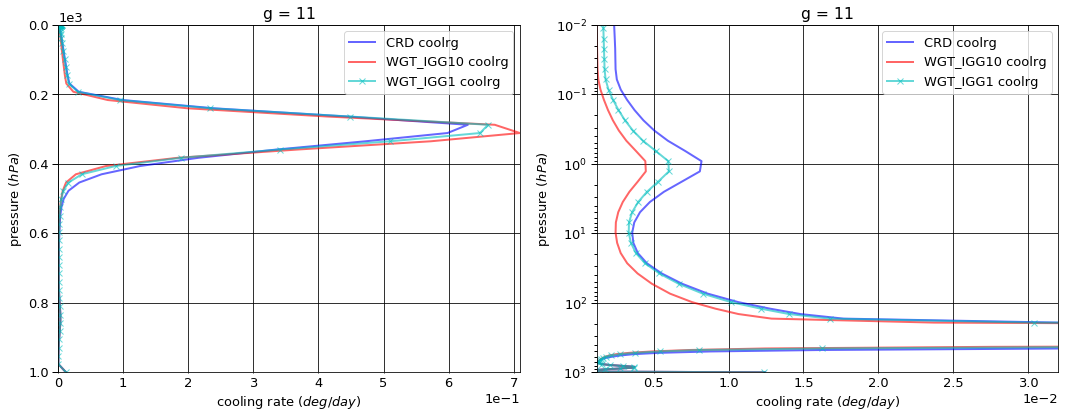

# Figure: cooling rate g-group 12

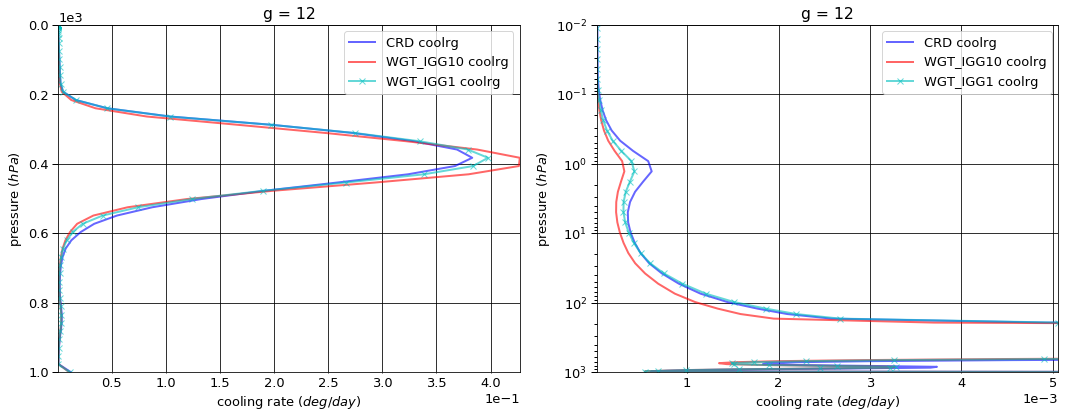

# Figure: cooling rate g-group total

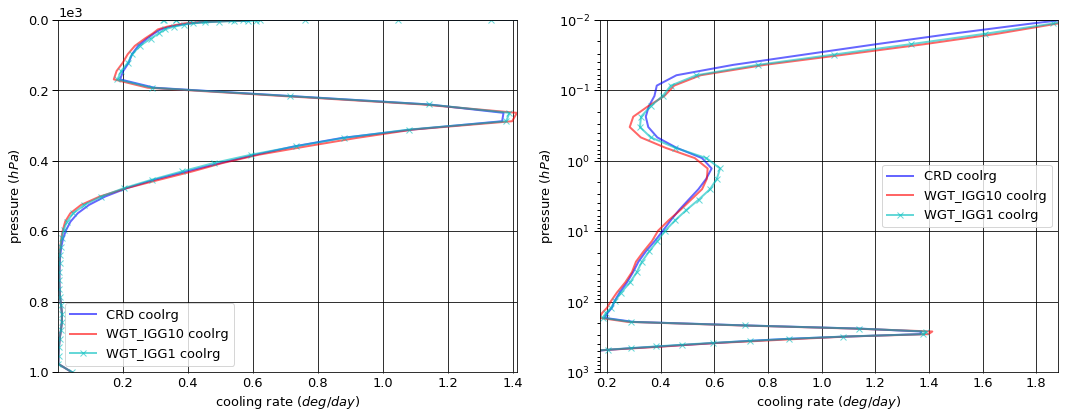

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.005210   0.000000 -0.005210
   1013.0   76     -0.008858   0.008837 -0.000020
2  0.0      1      -0.012624   0.000000 -0.012624
   1013.0   76     -0.020391   0.020342 -0.000049
3  0.0      1      -0.013945   0.000000 -0.013945
   1013.0   76     -0.016840   0.016805 -0.000035
4  0.0      1      -0.044823   0.000000 -0.044823
   1013.0   76     -0.053185   0.053069 -0.000116
5  0.0      1      -0.142349   0.000000 -0.142349
   1013.0   76     -0.183643   0.183226 -0.000417
6  0.0      1      -0.326520   0.000000 -0.326520
   1013.0   76     -0.466836   0.465781 -0.001055
7  0.0      1      -0.527429   0.000000 -0.527429
   1013.0   76     -0.821127   0.819290 -0.001836
8  0.0      1      -1.508517   0.000000 -1.508517
   1013.0   76     -2.472789   2.467256 -0.005533
9  0.0      1      -3.730416   0.000000 -3.730416
   1013.0   76     -6.046830   6.033271 -0.013559
10 0.0      1      -8.950779   0.000000 -8.950779
   1013.0   76    -13.749969  13.718809 -0.031160
11 0.0      1      -9.758116   0.000000 -9.758116
   1013.0   76    -14.293415  14.259139 -0.034276
12 0.0      1      -9.242351   0.000000 -9.242351
   1013.0   76    -12.939547  12.905533 -0.034013


WGT_IGG10


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.005032   0.000000 -0.005032
   1013.0   76     -0.008974   0.008953 -0.000021
2  0.0      1      -0.012484   0.000000 -0.012484
   1013.0   76     -0.020350   0.020301 -0.000049
3  0.0      1      -0.014214   0.000000 -0.014214
   1013.0   76     -0.017482   0.017440 -0.000042
4  0.0      1      -0.045772   0.000000 -0.045772
   1013.0   76     -0.054584   0.054453 -0.000130
5  0.0      1      -0.144168   0.000000 -0.144168
   1013.0   76     -0.186550   0.186104 -0.000446
6  0.0      1      -0.326179   0.000000 -0.326179
   1013.0   76     -0.474725   0.473591 -0.001135
7  0.0      1      -0.521700   0.000000 -0.521700
   1013.0   76     -0.837444   0.835443 -0.002002
8  0.0      1      -1.476344   0.000000 -1.476344
   1013.0   76     -2.521937   2.515909 -0.006028
9  0.0      1      -3.641266   0.000000 -3.641266
   1013.0   76     -6.162916   6.148186 -0.014730
10 0.0      1      -8.856835   0.000000 -8.856835
   1013.0   76    -13.970139  13.936749 -0.033390
11 0.0      1      -9.753676   0.000000 -9.753676
   1013.0   76    -14.277917  14.243792 -0.034125
12 0.0      1      -9.283878   0.000000 -9.283878
   1013.0   76    -12.540412  12.510439 -0.029973


WGT_IGG1


flug       fldg     fnetg
g  pressure level                                
1  0.0      1      -0.005044   0.000000 -0.005044
   1013.0   76     -0.008974   0.008953 -0.000021
2  0.0      1      -0.012569   0.000000 -0.012569
   1013.0   76     -0.020350   0.020301 -0.000049
3  0.0      1      -0.014161   0.000000 -0.014161
   1013.0   76     -0.017482   0.017440 -0.000042
4  0.0      1      -0.045574   0.000000 -0.045574
   1013.0   76     -0.054584   0.054453 -0.000130
5  0.0      1      -0.143955   0.000000 -0.143955
   1013.0   76     -0.186550   0.186104 -0.000446
6  0.0      1      -0.326259   0.000000 -0.326259
   1013.0   76     -0.474725   0.473591 -0.001135
7  0.0      1      -0.522285   0.000000 -0.522285
   1013.0   76     -0.837444   0.835443 -0.002002
8  0.0      1      -1.480127   0.000000 -1.480127
   1013.0   76     -2.521937   2.515909 -0.006028
9  0.0      1      -3.645262   0.000000 -3.645262
   1013.0   76     -6.162916   6.148186 -0.014730
10 0.0      1      -8.825741   0.000000 -8.825741
   1013.0   76    -13.970139  13.936749 -0.033390
11 0.0      1      -9.717308   0.000000 -9.717308
   1013.0   76    -14.277917  14.243792 -0.034125
12 0.0      1      -9.244399   0.000000 -9.244399
   1013.0   76    -12.540412  12.510439 -0.029973


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000178  0.000000  1.782000e-04
   1013.0   76    -0.000117  0.000115 -1.191157e-06
2  0.0      1      0.000140  0.000000  1.402940e-04
   1013.0   76     0.000041 -0.000041  4.290810e-07
3  0.0      1     -0.000269  0.000000 -2.691090e-04
   1013.0   76    -0.000642  0.000635 -6.482814e-06
4  0.0      1     -0.000949  0.000000 -9.488940e-04
   1013.0   76    -0.001399  0.001385 -1.420244e-05
5  0.0      1     -0.001819  0.000000 -1.819200e-03
   1013.0   76    -0.002907  0.002877 -2.923303e-05
6  0.0      1      0.000341  0.000000  3.410300e-04
   1013.0   76    -0.007889  0.007810 -7.963580e-05
7  0.0      1      0.005728  0.000000  5.728490e-03
   1013.0   76    -0.016317  0.016152 -1.651196e-04
8  0.0      1      0.032173  0.000000  3.217340e-02
   1013.0   76    -0.049148  0.048653 -4.948938e-04
9  0.0      1      0.089150  0.000000  8.915030e-02
   1013.0   76    -0.116085  0.114915 -1.170550e-03
10 0.0      1      0.093944  0.000000  9.394370e-02
   1013.0   76    -0.220170  0.217940 -2.230061e-03
11 0.0      1      0.004440  0.000000  4.439500e-03
   1013.0   76     0.015498 -0.015347  1.507080e-04
12 0.0      1     -0.041526  0.000000 -4.152640e-02
   1013.0   76     0.399135 -0.395094  4.040842e-03


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                  
1  0.0      1      0.000166  0.000000  1.663166e-04
   1013.0   76    -0.000117  0.000115 -1.191157e-06
2  0.0      1      0.000056  0.000000  5.558900e-05
   1013.0   76     0.000041 -0.000041  4.290810e-07
3  0.0      1     -0.000216  0.000000 -2.162620e-04
   1013.0   76    -0.000642  0.000635 -6.482814e-06
4  0.0      1     -0.000751  0.000000 -7.506350e-04
   1013.0   76    -0.001399  0.001385 -1.420244e-05
5  0.0      1     -0.001607  0.000000 -1.606520e-03
   1013.0   76    -0.002907  0.002877 -2.923303e-05
6  0.0      1      0.000261  0.000000  2.611900e-04
   1013.0   76    -0.007889  0.007810 -7.963580e-05
7  0.0      1      0.005144  0.000000  5.143710e-03
   1013.0   76    -0.016317  0.016152 -1.651196e-04
8  0.0      1      0.028390  0.000000  2.839000e-02
   1013.0   76    -0.049148  0.048653 -4.948938e-04
9  0.0      1      0.085155  0.000000  8.515460e-02
   1013.0   76    -0.116085  0.114915 -1.170550e-03
10 0.0      1      0.125038  0.000000  1.250382e-01
   1013.0   76    -0.220170  0.217940 -2.230061e-03
11 0.0      1      0.040808  0.000000  4.080770e-02
   1013.0   76     0.015498 -0.015347  1.507080e-04
12 0.0      1     -0.002047  0.000000 -2.047100e-03
   1013.0   76     0.399135 -0.395094  4.040842e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer          
1  0.000312    1      3.737309
   1001.112500 75     0.000007
2  0.000312    1      1.514985
   1001.112500 75     0.000018
3  0.000312    1      0.014109
   1001.112500 75     0.000013
4  0.000312    1      0.000024
   1001.112500 75     0.000042
5  0.000312    1      0.000020
   1001.112500 75     0.000151
6  0.000312    1      0.001969
   1001.112500 75     0.000383
7  0.000312    1      0.000015
   1001.112500 75     0.000667
8  0.000312    1      0.000108
   1001.112500 75     0.002011
9  0.000312    1      0.008111
   1001.112500 75     0.004928
10 0.000312    1      0.003409
   1001.112500 75     0.011324
11 0.000312    1      0.002126
   1001.112500 75     0.012454
12 0.000312    1      0.000015
   1001.112500 75     0.012354


WGT_IGG10


coolrg
g  pressure    layer          
1  0.000312    1      1.715413
   1001.112500 75     0.000008
2  0.000312    1      0.694993
   1001.112500 75     0.000018
3  0.000312    1      0.006780
   1001.112500 75     0.000015
4  0.000312    1      0.000016
   1001.112500 75     0.000047
5  0.000312    1      0.000017
   1001.112500 75     0.000162
6  0.000312    1      0.001282
   1001.112500 75     0.000412
7  0.000312    1      0.000016
   1001.112500 75     0.000727
8  0.000312    1      0.000076
   1001.112500 75     0.002190
9  0.000312    1      0.005449
   1001.112500 75     0.005352
10 0.000312    1      0.002125
   1001.112500 75     0.012132
11 0.000312    1      0.001069
   1001.112500 75     0.012399
12 0.000312    1      0.000009
   1001.112500 75     0.010890


WGT_IGG1


coolrg
g  pressure    layer          
1  0.000312    1      2.016769
   1001.112500 75     0.000008
2  0.000312    1      0.852177
   1001.112500 75     0.000018
3  0.000312    1      0.009064
   1001.112500 75     0.000015
4  0.000312    1      0.000019
   1001.112500 75     0.000047
5  0.000312    1      0.000019
   1001.112500 75     0.000162
6  0.000312    1      0.001444
   1001.112500 75     0.000412
7  0.000312    1      0.000018
   1001.112500 75     0.000727
8  0.000312    1      0.000088
   1001.112500 75     0.002190
9  0.000312    1      0.007210
   1001.112500 75     0.005352
10 0.000312    1      0.002897
   1001.112500 75     0.012132
11 0.000312    1      0.001476
   1001.112500 75     0.012399
12 0.000312    1      0.000012
   1001.112500 75     0.010890


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.021896e+00
   1001.112500 75     4.313708e-07
2  0.000312    1     -8.199919e-01
   1001.112500 75    -1.552910e-07
3  0.000312    1     -7.328861e-03
   1001.112500 75     2.348990e-06
4  0.000312    1     -7.804966e-06
   1001.112500 75     5.144872e-06
5  0.000312    1     -3.065252e-06
   1001.112500 75     1.059446e-05
6  0.000312    1     -6.870746e-04
   1001.112500 75     2.885611e-05
7  0.000312    1      4.223160e-07
   1001.112500 75     5.982438e-05
8  0.000312    1     -3.236274e-05
   1001.112500 75     1.793464e-04
9  0.000312    1     -2.662579e-03
   1001.112500 75     4.241721e-04
10 0.000312    1     -1.284466e-03
   1001.112500 75     8.079340e-04
11 0.000312    1     -1.057217e-03
   1001.112500 75    -5.470800e-05
12 0.000312    1     -6.032680e-06
   1001.112500 75    -1.463991e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.720540e+00
   1001.112500 75     4.313708e-07
2  0.000312    1     -6.628076e-01
   1001.112500 75    -1.552910e-07
3  0.000312    1     -5.044596e-03
   1001.112500 75     2.348990e-06
4  0.000312    1     -4.400820e-06
   1001.112500 75     5.144872e-06
5  0.000312    1     -9.110800e-07
   1001.112500 75     1.059446e-05
6  0.000312    1     -5.256221e-04
   1001.112500 75     2.885611e-05
7  0.000312    1      2.793650e-06
   1001.112500 75     5.982438e-05
8  0.000312    1     -1.973894e-05
   1001.112500 75     1.793464e-04
9  0.000312    1     -9.017017e-04
   1001.112500 75     4.241721e-04
10 0.000312    1     -5.121162e-04
   1001.112500 75     8.079340e-04
11 0.000312    1     -6.504171e-04
   1001.112500 75    -5.470800e-05
12 0.000312    1     -2.471566e-06
   1001.112500 75    -1.463991e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.263080,0.000000,-34.26308
1013.0,76,-51.073429,50.951358,-0.12207



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.081549,0.000000,-34.081549
1013.0,76,-51.073429,50.951359,-0.122070



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-33.982683,0.000000,-33.982683
1013.0,76,-51.073429,50.951359,-0.122070



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.815313e-01,0.000000e+00,1.815313e-01
1013.0,76,9.414000e-07,2.125000e-07,6.094400e-07



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.803968e-01,0.000000e+00,2.803968e-01
1013.0,76,9.414000e-07,2.125000e-07,6.094400e-07


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.282200
1001.112500,75,0.044352



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.427243
1001.112500,75,0.044352



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.891193
1001.112500,75,0.044352



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.854957e+00
1001.112500,75,-2.016082e-07



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.391007e+00
1001.112500,75,-2.016082e-07


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000188,0.000176
2,0.000406,0.000398
3,0.000500,0.000342
4,0.001187,0.001069
5,0.004281,0.003653
6,0.010625,0.009295
7,0.018375,0.016397
8,0.060125,0.049379
9,0.144469,0.120668


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.826058e-16
2,3.064953e-17
3,5.144378e-18
4,1.724158e-17
5,3.045007e-18
6,5.377738e-19
7,8.245586e-19
8,1.498041e-19
9,2.721609e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.826058e-16,NaN,0.000188,0.000176,0.000188,0.000176,1.0
2,3.064953e-17,0.167845,0.000406,0.000398,0.000594,0.000574,1.0
3,5.144378e-18,0.167845,0.000500,0.000342,0.001094,0.000916,1.0
4,1.724158e-17,3.351537,0.001187,0.001069,0.002281,0.001985,30.0
5,3.045007e-18,0.176608,0.004281,0.003653,0.006563,0.005638,30.0
6,5.377738e-19,0.176608,0.010625,0.009295,0.017188,0.014933,30.0
7,8.245586e-19,1.533282,0.018375,0.016397,0.035562,0.031330,300.0
8,1.498041e-19,0.181678,0.060125,0.049379,0.095687,0.080708,300.0
9,2.721609e-20,0.181678,0.144469,0.120668,0.240156,0.201376,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
